# Introduction

Using the dataset "Amazon Fine Food's Review" from Kaggle, the task is to predict the rating (Postive / Negative) based on the feedback the users had provided. The dataset can be downloaded at

https://www.kaggle.com/snap/amazon-fine-food-reviews

# Content

<ul>
  <li><h3>1. Import Packages</h3></li>
  <li><h3>2. Understanding the Data</h3></li>  
  <li><h3>3. Exploratory Data Analysis</h3>
    <ul>
      <li>3a. Data Cleaning - Deduplication</li>
      <li>3b. Data Cleaning - Erroneous Data</li>
    </ul>
  </li>
  <li><h3>4. Data Processing</h3>
    <ul>
      <li>4a. Text Processing</li>
      <li>4b. Feature Engineering</li>
    </ul>
  </li> 
  <li><h3>5. Text Classification</h3>
    <ul>
      <li>5a. Selection and Splitting of Data</li>
      <li>5b. Defining the Functions</li>
      <li>5c. Selection of Models
        <ul>
          <li>5ci. Naive Bayes</li>
          <li>5cii. Logistic Regression</li>
          <li>5ciii. Linear Support Vector Machine</li>
          <li>5civ. Random Forest</li>  
        </ul>
      </li>
      <li>5d. N-Gram</li> 
      <li>5e. Common / Rare Words Removal</li>  
      <li>5f. Summary vs Text vs Summary+Text</li> 
      <li>5g. Regularization</li>  
    </ul>
  </li>     
  <li><h3>6. Final Model</h3></li> 
  <li><h3>7. Conclusion</h3></li> 
</ul>

## 1. Import Packages

Begin by importing the relevant packages. Note that you have to do some additional prior installations when importing the nltk package.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re # For Regular Expression
from IPython.display import display

import nltk
from nltk.corpus import stopwords
from textblob import Word
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

## 2. Understanding the Data

The Amazon Fine Food Reviews dataset consists of user's reviews of fine foods from Amazon.
<br>
Number of reviews (rows): 568,454
<br>
Number of users: 256,059
<br>
Number of products: 74,258
<br>
Timespan: Oct 1999 - Oct 2012
<br>
Number of Attributes: 10
<br>
<br>
Attribute Information:
<br>
__Id__ - Row Id
<br>
__ProductId__ - Unique identifier for the product
<br>
__UserId__ - Unqiue identifier for the user
<br>
__ProfileName__ - Profile name of the user
<br>
__HelpfulnessNumerator__ - Number of users who found the review helpful
<br>
__HelpfulnessDenominator__ - Number of users who indicated whether they found the review helpful or not
<br>
__Score__ - Rating between 1 and 5
<br>
__Time__ - Timestamp for the review
<br>
__Summary__ - Brief summary of the review
<br>
__Text__ - Text of the review
<br>
<br>
For this task, we will be focusing on __Score__ (to be processed later), __Summary__ and __Text__.

In [2]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3. Exploratory Data Analysis

### 3a. Data Cleaning - Deduplication

Given the reviews data had many duplicate entries, it was necessary to remove duplicates to get unbiased results for data analysis. An example of duplicated entries is shown below.
<br>
<br>
The reviews provided by the same user, Geetha Krishnan, have the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text. It turned out that these reviews belong to the same product with just a little variation in terms of its flavour or quantity. For example, 
<br>
<br>
ProductId = B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)
<br>
ProductId = B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on
<br>
<br>
Hence, these duplicated rows are removed to avoid redunancy. Only the first instance of the review is kept.
<br>
<br>
Approximately, 30% of the data is removed as a result.

In [3]:
# An example of duplicated entry
df[df.UserId == "AR5J8UI46CURR"]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
# Sort dataframe by ProductId in ascending order first, then remove duplicated entries
df1 = df.sort_values("ProductId", axis = 0, ascending = True, inplace = False, kind = "quicksort", na_position = "last")
df1 = df1.drop_duplicates(subset = {"UserId", "ProfileName", "Time", "Summary", "Text"})

In [5]:
# % of data remaining
len(df1) / len(df) * 100

69.51697059040836

### 3b. Data Cleaning - Erroneous Data

There are two rows with HelpfulnessNumerator values greater than HelpfulnessDenominator, which is not possible. These rows are removed from analysis.

In [6]:
# Rows which have greaters HelpfulnessNumerator values than HelpfulnessDenominator
df1[df1.HelpfulnessNumerator > df1.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
df1 = df1[df1.HelpfulnessNumerator <= df1.HelpfulnessDenominator]

Below shows the distribution of scores among the remaining data.

(395170, 10)
5    251736
4     56225
1     36520
3     29846
2     20843
Name: Score, dtype: int64


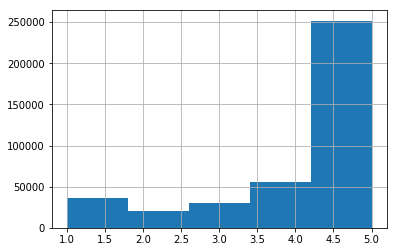

In [8]:
print(df1.shape)
print(df1["Score"].value_counts())
df1["Score"].hist(bins = 5)

## 4. Data Processing

### 4a. Text Preprocessing

After removing duplicated and errorneous data, we will now proceed to process the text summary and reviews given by the users.
<br>
The text are processed in the following order:
<br>
<ol>
1. Removal of html tags.
<br>
2. Removal of any punctuations or limited set of special characters like , or . or # etc.
<br>
3. Check if the word is made up of english letters and is not alpha-numeric
<br>
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
<br>
5. Convert the word to lowercase
<br>
6. Removal of Stopwords
<br>
7. Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
<br>
</ol>
Credit: https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes

In [9]:
df1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...


In [10]:
stop = set(stopwords.words("english")) # set of stopwords
sno = nltk.stem.SnowballStemmer("english") # initialising the snowball stemmer

def cleanhtml(sentence): # function to clean the word of any html-tags
    cleanr = re.compile("<.*?>")
    cleantext = re.sub(cleanr, " ", sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    
    # Remove characters these characters ? ! " # : ; @ %
    cleaned = re.sub(r'[?|!|\'|"|#|:|;|@|%]', r'', sentence)
    
    # Remove characters these characters . , ) ( \ /
    cleaned = re.sub(r'[.|,|)|(|\\|/]', r' ', cleaned)
    return cleaned

print("### List of stopwords")
print(stop)
print("        ")
print("### An Example of Snowball Stemming")
print(sno.stem("generously"))

### List of stopwords
{'ourselves', 'if', 'them', 'after', "she's", 'above', 'how', 'own', 'an', 'because', 'we', 'ain', 'o', 'into', 'hadn', 'on', 'why', 'isn', 'was', "that'll", 'themselves', 'a', "won't", 'about', 'him', 'm', 'needn', "couldn't", 'mustn', "wasn't", 'until', 're', "isn't", "weren't", 'does', 'no', 'be', 'itself', 'all', 'you', "shan't", 'its', 'while', 'or', 'hasn', 'mightn', 'myself', 'before', 'when', 'ma', 'down', 'i', 'yourselves', 'both', "you'd", "hasn't", 'once', 've', 'didn', "wouldn't", 'same', 'having', 'where', 'up', 'any', 'haven', "haven't", 'below', 'further', "didn't", 'doesn', 'her', 'now', 'yours', 'weren', 'will', "doesn't", 'most', 'their', 'is', 'couldn', 'should', 'just', 'each', 'under', 'am', 'during', 'it', 'as', "mightn't", 'has', 'by', 'but', 'theirs', 'such', 'he', "needn't", 'again', "you'll", 'what', 'off', 'out', 'shouldn', 'other', 'doing', "you're", 'ours', 'my', 'between', 'who', 'hers', "you've", 'don', 'which', 'they', 'been', 'nor'

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on more than 400k sentences.

# Cleaning Steps
# 1. Remove html tags
# 2. Remove and special characters like , or . or # etc.
# 3. Check if the word is made up of english letters and is not alpha-numeric
# 4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
# 5. Convert the word to lowercase
# 6. Remove Stopwords
# 7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming). Link:
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def clean_sentence(text):
    text = str(text)
    filtered_sentence = ""
    # Step 1
    sent = cleanhtml(text)
    for w in sent.split():  
        # Step 2
        for cleaned_words in cleanpunc(w).split():
            # # Step 3 and 4
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):   
                # Step 5 and 6
                if(cleaned_words.lower() not in stop):
                    # Step 7
                    s = (sno.stem(cleaned_words.lower()))
                    filtered_sentence = filtered_sentence + " " + s
                else:
                    continue
            else:
                continue 
    return filtered_sentence #final string of cleaned words

In [12]:
start = time.clock()
df1["Cleaned_Summary"] = df1.Summary.apply(clean_sentence)
df1["Cleaned_Text"] = df1.Text.apply(clean_sentence)
df1.head()
print("Time taken to complete text processing: {} minutes".format(round((time.clock() - start) / 60, 1)))

Time taken to complete text processing: 4.6 minutes


### 4b. Feature Engineering

For this task, we will be predicting whether a review is positive or negative. Hence, reviews with a score of 1 or 2 will be grouped as negative whereas reviews with a score of 4 or 5 are grouped as positive. Reviews with a score of 3 are excluded from the analysis.

In [13]:
def get_rating(score):
    if score == 1 or score == 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"
df1["Rating"] = df1.Score.apply(get_rating)

Given that the summary column also provides some additional information about how a user feels about the product, we will be appending it together with the text. The analysis will be conducted on both the "Text" variable and the newly created "Summary_Text" variable in the later section.

In [14]:
df1["Cleaned_Summary_Text"] = df1[["Cleaned_Summary", "Cleaned_Text"]].apply(lambda x: str(x[0]) + " " + str(x[1]), axis=1)

Creating a variable called "category id" for now for access to the confusion matrix later.

In [15]:
df2 = df1[["ProductId", "Score", "Summary", "Cleaned_Summary", "Text", "Cleaned_Text", "Rating", "Cleaned_Summary_Text"]]
df2 = df2[df2.Rating != "Neutral"]
df2["category_id"] = df2["Rating"].factorize()[0]
category_id_df = df2[["Rating", "category_id"]].drop_duplicates().sort_values("category_id")
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[["category_id", "Rating"]].values)
df2.head()

,ProductId,Score,Summary,Cleaned_Summary,Text,Cleaned_Text,Rating,Cleaned_Summary_Text,category_id
150528,0006641040,4,"Nice cadence, catchy rhymes",nice cadenc catchi rhyme,In June<br />I saw a charming group<br />of ro...,june saw charm group rose begin droop pep chi...,Positive,nice cadenc catchi rhyme june saw charm grou...,0
150506,0006641040,4,chicken soup with rice months,chicken soup rice month,This is a fun way for children to learn their ...,fun way children learn month year learn poem ...,Positive,chicken soup rice month fun way children lea...,0
150505,0006641040,4,"Love the book, miss the hard cover version",love book miss hard cover version,"I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi ...,Positive,love book miss hard cover version grew read ...,0
150504,0006641040,4,A classic,classic,Get the movie or sound track and sing along wi...,get movi sound track sing along carol king gr...,Positive,classic get movi sound track sing along caro...,0
150503,0006641040,4,Chicken Soup with Rice,chicken soup rice,A very entertaining rhyming story--cleaver and...,entertain rhyme catchi illustr imagin fit rig...,Positive,chicken soup rice entertain rhyme catchi ill...,0


In [16]:
df2[["Cleaned_Summary", "Cleaned_Text", "Cleaned_Summary_Text"]].head()

,Cleaned_Summary,Cleaned_Text,Cleaned_Summary_Text
150528,nice cadenc catchi rhyme,june saw charm group rose begin droop pep chi...,nice cadenc catchi rhyme june saw charm grou...
150506,chicken soup rice month,fun way children learn month year learn poem ...,chicken soup rice month fun way children lea...
150505,love book miss hard cover version,grew read sendak book watch realli rosi movi ...,love book miss hard cover version grew read ...
150504,classic,get movi sound track sing along carol king gr...,classic get movi sound track sing along caro...
150503,chicken soup rice,entertain rhyme catchi illustr imagin fit rig...,chicken soup rice entertain rhyme catchi ill...


## 5. Text Classification

### 5a. Selection and Splitting of Data

To prevent biasness in the classification model, an equal number of samples will be sampled from both the positive and negative group.

In [17]:
df2.Rating.value_counts()

Positive    307961
Negative     57363
Name: Rating, dtype: int64

In [18]:
# For simplicity, I will subsample data of sample size as the negative group from the positive group 
df2_positive = df2[df2.Rating == "Positive"]
df2_positive = df2_positive.sample(n = 57363)

df2_negative = df2[df2.Rating == "Negative"]
# df_negative = df_negative.sample(frac = 57363)

df2_neutral = df2[df2.Rating == "Neutral"]

df2_selected = pd.concat([df2_negative, df2_positive])
df2_nonselected = df2[df2.index.isin(list(df2_selected.index)) == False]  # Unused
df2.columns

Index(['ProductId', 'Score', 'Summary', 'Cleaned_Summary', 'Text',
       'Cleaned_Text', 'Rating', 'Cleaned_Summary_Text', 'category_id'],
      dtype='object')

Split the cell into train and test set. The split is done on both the full data (to show that the analysis is biased if the sample size is skewed towards a group) and the selected data.

In [19]:
# Split into train and test set for selected data
x_train_df, x_test_df, y_train, y_test, indices_train, indices_test = train_test_split(df2_selected[["ProductId", "Score", "Cleaned_Summary", "Cleaned_Text", "Cleaned_Summary_Text"]], 
                                                                                       df2_selected.Rating, df2_selected.index, random_state = 0)
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
print('X_train shape: ', x_train.shape)
print('X_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# Split into train and test set for all data
x_train_df_full, x_test_df_full, y_train_full, y_test_full, indices_train_full, indices_test_full = train_test_split(df2[["ProductId", "Score", "Cleaned_Summary", "Cleaned_Text", "Cleaned_Summary_Text"]], 
                                                                                                                     df2.Rating, df2.index, random_state = 0)
x_train_full = x_train_df_full["Cleaned_Text"]
x_test_full = x_test_df_full["Cleaned_Text"]
print('X_train_full shape: ', x_train_full.shape)
print('X_test_full shape: ', x_test_full.shape)
print('y_train_full shape: ', y_train_full.shape)
print('y_test_full shape: ', y_test_full.shape)

X_train shape:  (86044,)
X_test shape:  (28682,)
y_train shape:  (86044,)
y_test shape:  (28682,)
X_train_full shape:  (273993,)
X_test_full shape:  (91331,)
y_train_full shape:  (273993,)
y_test_full shape:  (91331,)


### 5b. Defining the Functions

For this task, I will be mainly using two functions. The first is to plot the confusion matrix to show the accuracy score for each group and the second is used to fit the classification model.

In [20]:
# Function to plot Confusion Matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)
#    plt.figure(figsize=(7,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def plot_model(xtrain, xtest, ytrain, ytest, vect, tfidf, clf, name_of_classification, showMatrix):
    pipeline = Pipeline([('vect', vect),
                         ('tfidf', tfidf),
                         ('clf', clf),
                        ])
    pipeline.fit(xtrain, ytrain)
    prediction = pipeline.predict(xtest)

    accuracy = accuracy_score(ytest, prediction)
    sns.set(style = "whitegrid", font_scale = 1)
    matrix = confusion_matrix(ytest, prediction)
    if showMatrix:
        plot_confusion_matrix(matrix, classes = ["Negative", "Positive"], normalize = True,
                              title = "Confusion Matrix of {} Classification \nModel With Normalization".format(name_of_classification))

    class_report = classification_report(ytest, prediction)
    return {"pipeline": pipeline, 
            "prediction": prediction,
            "accuracy_score": accuracy, 
            "confusion_matrix": matrix, 
            "class_report": class_report}

In [22]:
Counter(list(df1["Rating"]))

Counter({'Positive': 307961, 'Negative': 57363, 'Neutral': 29846})

### 5c. Selection of Models

Four common text classification models will be used in this analysis. They are:
<br>
<ol>
1. Naive Bayes
<br>
2. Logistic Regression
<br>
3. Linear Support Vector Machine
<br>
4. Random Forest
<br>
</ol>
<br>
For all models, the text inputs will be converted to a matrix of token counts (using CountVectorizer()) and then transformed to a normalized tf-idf representation (using TfidfTransformer()).
<br>
<br>
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur too frequently in the entire dataset.
<br>
<br>
Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

### 5ci. Naive Bayes

[[12129  2140]
 [ 1988 12425]]
0.8560769820793529
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85     14269
    Positive       0.85      0.86      0.86     14413

   micro avg       0.86      0.86      0.86     28682
   macro avg       0.86      0.86      0.86     28682
weighted avg       0.86      0.86      0.86     28682

Time taken to complete fitting Naive Bayes model: 0.1 minutes


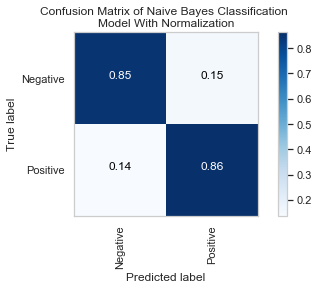

In [23]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
NB = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                vect = CountVectorizer(),
                tfidf = TfidfTransformer(),
                clf = MultinomialNB(), 
                name_of_classification = "Naive Bayes",
                showMatrix = True)
print(NB["confusion_matrix"])
print(NB["accuracy_score"])
print(NB["class_report"])
print("Time taken to complete fitting Naive Bayes model: {} minutes".format(round((time.clock() - start) / 60, 1)))

### 5cii. Logistic Regression

[[12544  1725]
 [ 1756 12657]]
0.8786346837737954
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     14269
    Positive       0.88      0.88      0.88     14413

   micro avg       0.88      0.88      0.88     28682
   macro avg       0.88      0.88      0.88     28682
weighted avg       0.88      0.88      0.88     28682

Time taken to complete fitting Linear Regression model: 0.7 minutes


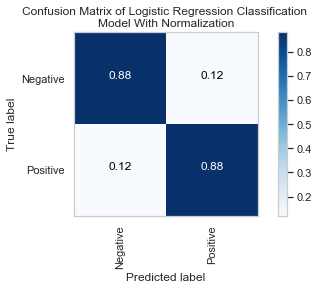

In [24]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
LR = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                vect = CountVectorizer(),
                tfidf = TfidfTransformer(),
                clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000), 
                name_of_classification = "Logistic Regression",
                showMatrix = True)
print(LR["confusion_matrix"])
print(LR["accuracy_score"])
print(LR["class_report"])
print("Time taken to complete fitting Linear Regression model: {} minutes".format(round((time.clock() - start) / 60, 1)))

### 5ciii. Linear Support Vector Machine

[[12459  1810]
 [ 1782 12631]]
0.8747646607628478
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     14269
    Positive       0.87      0.88      0.88     14413

   micro avg       0.87      0.87      0.87     28682
   macro avg       0.87      0.87      0.87     28682
weighted avg       0.87      0.87      0.87     28682

Time taken to complete Linear SVM model: 0.1 minutes


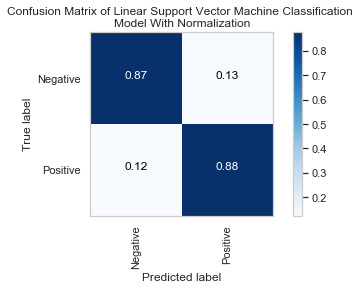

In [25]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
SVC = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                 vect = CountVectorizer(),
                 tfidf = TfidfTransformer(),
                 clf = LinearSVC(), 
                 name_of_classification = "Linear Support Vector Machine",
                 showMatrix = True)
print(SVC["confusion_matrix"])
print(SVC["accuracy_score"])
print(SVC["class_report"])
print("Time taken to complete Linear SVM model: {} minutes".format(round((time.clock() - start) / 60, 1)))

### 5civ. Random Forest

/anaconda3/envs/smrt/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[12242  2027]
 [ 3924 10489]]
0.7925179555121679
              precision    recall  f1-score   support

    Negative       0.76      0.86      0.80     14269
    Positive       0.84      0.73      0.78     14413

   micro avg       0.79      0.79      0.79     28682
   macro avg       0.80      0.79      0.79     28682
weighted avg       0.80      0.79      0.79     28682

Time taken to complete Random Forest model: 0.4 minutes


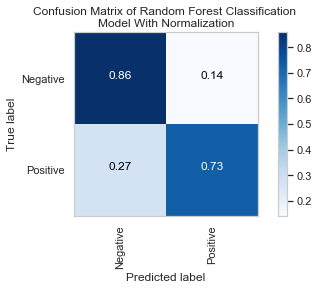

In [26]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
RF = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                vect = CountVectorizer(),
                tfidf = TfidfTransformer(),
                clf = RandomForestClassifier(), 
                name_of_classification = "Random Forest",
                showMatrix = True)
print(RF["confusion_matrix"])
print(RF["accuracy_score"])
print(RF["class_report"])
print("Time taken to complete Random Forest model: {} minutes".format(round((time.clock() - start) / 60, 1)))

### 5d. N-Gram

Based on the results above, Logistic Regression will be used in subsequent analysis since it gives the highest accuracy. Now we will work on N-Gram, a contiguous sequence of n items from a given sample of text or speech.

In [28]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
LR_ngram_12 = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                         vect = CountVectorizer(ngram_range=(1, 2)),
                         tfidf = TfidfTransformer(),
                         clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                         name_of_classification = "Logistic Regression",
                         showMatrix = False)

LR_ngram_13 = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                         vect = CountVectorizer(ngram_range=(1, 3)),
                         tfidf = TfidfTransformer(),
                         clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                         name_of_classification = "Logistic Regression",
                         showMatrix = False)

LR_ngram_14 = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                         vect = CountVectorizer(ngram_range=(1, 4)),
                         tfidf = TfidfTransformer(),
                         clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                         name_of_classification = "Logistic Regression",
                         showMatrix = False)

LR_ngram_15 = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                         vect = CountVectorizer(ngram_range=(1, 5)),
                         tfidf = TfidfTransformer(),
                         clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                         name_of_classification = "Logistic Regression",
                         showMatrix = False)

print("Accuracy for bigram: {}. Accuracy for trigram: {}".format(LR_ngram_12["accuracy_score"], LR_ngram_13["accuracy_score"]))
print("Accuracy for four-gram: {}. Accuracy for five-gram: {}".format(LR_ngram_14["accuracy_score"], LR_ngram_15["accuracy_score"]))
print("Time taken to complete 4 Logistic Regression models with n-gram: {} minutes".format(round((time.clock() - start) / 60, 1)))

Accuracy for bigram: 0.8915696255491249. Accuracy for trigram: 0.886688515445227
Accuracy for four-gram: 0.8832020082281571. Accuracy for five-gram: 0.878564953629454
Time taken to complete 4 Logistic Regression models with n-gram: 49.6 minutes


Based on the results above, we will be using the combination of unigram and bigram (ngram_range = (1, 2)) since higher values of gram do not increase the accuracy of the model. The accuracy is increased by about 1% with the use of unigram and bigram.

### 5e. Common / Rare Words Removal

Next we will remove words that occur too rarely and frequently in the dataset. Words that occur only once will be removed from the analysis since they are unique words. There are two words that are unusually of high frequency (more than 40000). These words are also removed from the analysis.
<br>
<br>
These are specified in the "min_df" and "max_df" parameter in the CountVectorizer() function.

In [29]:
# Remove common words
freq = pd.Series(' '.join(x_train).split()).value_counts()
print("Top 10 lowest frequency with their respective number of words belonging to that frequency")
print(freq.value_counts().sort_index()[0:10])
print("Top 10 highest frequency with their respective number of words belonging to that frequency")
print(freq.value_counts().sort_index()[-10:])
print(len(x_train))

Top 10 lowest frequency with their respective number of words belonging to that frequency
1     16027
2      4296
3      2249
4      1418
5      1070
6       826
7       627
8       535
9       466
10      369
dtype: int64
Top 10 highest frequency with their respective number of words belonging to that frequency
21550    1
21990    1
25624    1
26023    1
27090    1
28991    1
30370    1
34356    1
44000    1
44464    1
dtype: int64
86044


[[12719  1550]
 [ 1512 12901]]
0.8932431490133185
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89     14269
    Positive       0.89      0.90      0.89     14413

   micro avg       0.89      0.89      0.89     28682
   macro avg       0.89      0.89      0.89     28682
weighted avg       0.89      0.89      0.89     28682

Time taken to complete Logistic Regression with min/max_df: 2.8 minutes


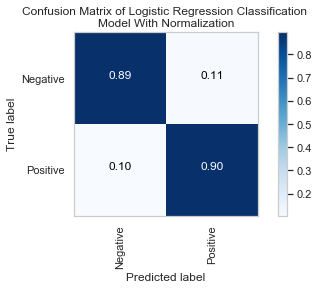

In [30]:
start = time.clock()
x_train = x_train_df["Cleaned_Text"]
x_test = x_test_df["Cleaned_Text"]
LR_ngram_12_freq = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                              vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                              tfidf = TfidfTransformer(),
                              clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                              name_of_classification = "Logistic Regression",
                              showMatrix = True)
print(LR_ngram_12_freq["confusion_matrix"])
print(LR_ngram_12_freq["accuracy_score"])
print(LR_ngram_12_freq["class_report"])
print("Time taken to complete Logistic Regression with min/max_df: {} minutes".format(round((time.clock() - start) / 60, 1)))

The removal of rare and common words increases the accuracy by less than 1%, hence it might not be too relevant for this task.

### 5f. Summary vs Text vs Summary+Text

Next, we will test our model on the summary column and the summary_text column that is newly featured earlier.

[[11871  2398]
 [ 2322 12091]]
0.8354368593542989
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83     14269
    Positive       0.83      0.84      0.84     14413

   micro avg       0.84      0.84      0.84     28682
   macro avg       0.84      0.84      0.84     28682
weighted avg       0.84      0.84      0.84     28682

Time taken to complete Logistic Regression on Summary: 0.3 minutes


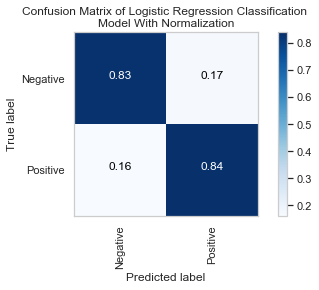

In [31]:
start = time.clock()
x_train = x_train_df["Cleaned_Summary"]
x_test = x_test_df["Cleaned_Summary"]
LR_ngram_12_freq_summary = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                                      vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                                      tfidf = TfidfTransformer(),
                                      clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                                      name_of_classification = "Logistic Regression",
                                      showMatrix = True)
print(LR_ngram_12_freq_summary["confusion_matrix"])
print(LR_ngram_12_freq_summary["accuracy_score"])
print(LR_ngram_12_freq_summary["class_report"])
print("Time taken to complete Logistic Regression on Summary: {} minutes".format(round((time.clock() - start) / 60, 1)))

[[13004  1265]
 [ 1234 13179]]
0.9128721846454222
              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91     14269
    Positive       0.91      0.91      0.91     14413

   micro avg       0.91      0.91      0.91     28682
   macro avg       0.91      0.91      0.91     28682
weighted avg       0.91      0.91      0.91     28682

Time taken to complete Logistic Regression on Summary + Text: 2.3 minutes


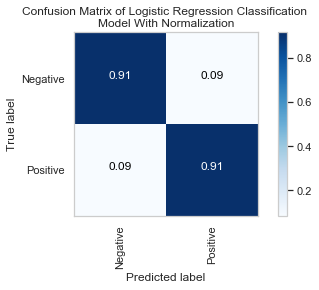

In [32]:
start = time.clock()
x_train = x_train_df["Cleaned_Summary_Text"]
x_test = x_test_df["Cleaned_Summary_Text"]
LR_ngram_12_freq_summaryText = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                                          vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                                          tfidf = TfidfTransformer(),
                                          clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                                          name_of_classification = "Logistic Regression",
                                          showMatrix = True)
print(LR_ngram_12_freq_summaryText["confusion_matrix"])
print(LR_ngram_12_freq_summaryText["accuracy_score"])
print(LR_ngram_12_freq_summaryText["class_report"])
print("Time taken to complete Logistic Regression on Summary + Text: {} minutes".format(round((time.clock() - start) / 60, 1)))

Analysis on the summary_text column increased the accuracy by about 2%. 
<br>
<br>
Now we will test our model on the entire dataset.

[[10640  3633]
 [ 1244 75814]]
0.9466008255685364
              precision    recall  f1-score   support

    Negative       0.90      0.75      0.81     14273
    Positive       0.95      0.98      0.97     77058

   micro avg       0.95      0.95      0.95     91331
   macro avg       0.92      0.86      0.89     91331
weighted avg       0.95      0.95      0.94     91331

Time taken to complete Logistic Regression on Text on whole dataset: 12.1 minutes


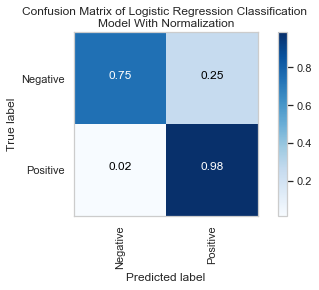

In [33]:
start = time.clock()
x_train_full = x_train_df_full["Cleaned_Summary_Text"]
x_test_full = x_test_df_full["Cleaned_Summary_Text"]
LR_full_ngram_12_freq = plot_model(xtrain = x_train_full, xtest = x_test_full, ytrain = y_train_full, ytest = y_test_full,
                                   vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                                   tfidf = TfidfTransformer(),
                                   clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                                   name_of_classification = "Logistic Regression",
                                   showMatrix = True)
print(LR_full_ngram_12_freq["confusion_matrix"])
print(LR_full_ngram_12_freq["accuracy_score"])
print(LR_full_ngram_12_freq["class_report"])
print("Time taken to complete Logistic Regression on Text on whole dataset: {} minutes".format(round((time.clock() - start) / 60, 1)))

Due to skewed sample sizes, there is a significant number of misclassified case for the negative group. Hence, the model will not be fitted on the entire dataset

### 5g. Regularization

Next we will tune the model by changing the values of the inverse regularization term found in the logistic regression function.
<br>
<br>
Link: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [34]:
start = time.clock()
x_train = x_train_df["Cleaned_Summary_Text"]
x_test = x_test_df["Cleaned_Summary_Text"]
c_values = [0.001, 0.01, 0.1, 1.0] + list(np.arange(5, 35, 5))
score = []
for c in c_values:

    LR_ngram_12_freq_summaryText = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                                              vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                                              tfidf = TfidfTransformer(),
                                              clf = LogisticRegression(C = c, solver = "lbfgs", multi_class = "multinomial", max_iter = 10000),
                                              name_of_classification = "Logistic Regression",
                                              showMatrix = False)
    print("C: {}, Accuracy Score: {}".format(c, LR_ngram_12_freq_summaryText["accuracy_score"]))
    score.append(LR_ngram_12_freq_summaryText["accuracy_score"])
    if c == 100.0:
        plt.plot(c_values, score, marker = '*') 
        plt.title("Accuracy Score vs c")
        plt.xlabel('value of c')
        plt.ylabel('Accuracy Score')
        plt.show()
    
# print(SVC_ngram_12_freq_summaryText["confusion_matrix"])
# print(SVC_ngram_12_freq_summaryText["accuracy_score"])
# print(SVC_ngram_12_freq_summaryText["class_report"])
print("Time taken to complete Logistic Regression Grid Search: {} minutes".format(round((time.clock() - start) / 60, 1)))

C: 0.001, Accuracy Score: 0.8568440136671083
C: 0.01, Accuracy Score: 0.8716616693396555
C: 0.1, Accuracy Score: 0.8953350533435604
C: 1.0, Accuracy Score: 0.9128721846454222
C: 5, Accuracy Score: 0.9167422076563698
C: 10, Accuracy Score: 0.9169165330172233
C: 15, Accuracy Score: 0.9168119378007112
C: 20, Accuracy Score: 0.9167770727285406
C: 25, Accuracy Score: 0.9167770727285406
C: 30, Accuracy Score: 0.9166027473676871
Time taken to complete Logistic Regression Grid Search: 37.5 minutes


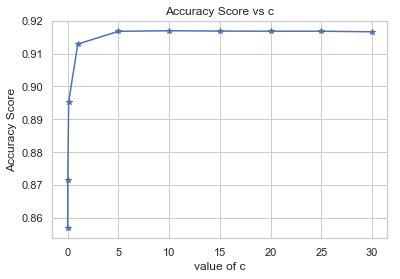

In [35]:
plt.plot(c_values, score, marker = '*') 
plt.title("Accuracy Score vs c")
plt.xlabel('value of c')
plt.ylabel('Accuracy Score')
plt.show()

We will use a value of 10 for the inverse regularization term since higher values do not affect the accuracy much.

## 6. Final Model

[[13050  1219]
 [ 1164 13249]]
0.9169165330172233
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.92     14269
    Positive       0.92      0.92      0.92     14413

   micro avg       0.92      0.92      0.92     28682
   macro avg       0.92      0.92      0.92     28682
weighted avg       0.92      0.92      0.92     28682

Time taken to complete Logistic Regression on Summary: 5.3 minutes


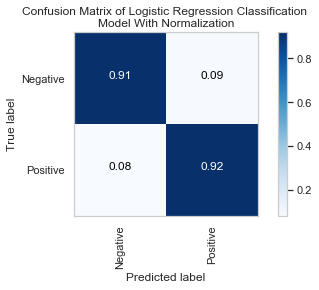

In [36]:
start = time.clock()
x_train = x_train_df["Cleaned_Summary_Text"]
x_test = x_test_df["Cleaned_Summary_Text"]
LR_ngram_12_freq_summary = plot_model(xtrain = x_train, xtest = x_test, ytrain = y_train, ytest = y_test,
                                      vect = CountVectorizer(ngram_range=(1, 2), max_df = 0.5, min_df = 2),
                                      tfidf = TfidfTransformer(),
                                      clf = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 10000, C = 10),
                                      name_of_classification = "Logistic Regression",
                                      showMatrix = True)
print(LR_ngram_12_freq_summary["confusion_matrix"])
print(LR_ngram_12_freq_summary["accuracy_score"])
print(LR_ngram_12_freq_summary["class_report"])
print("Time taken to complete Logistic Regression on Summary: {} minutes".format(round((time.clock() - start) / 60, 1)))

Below show some examples of misclassified cases.

In [37]:
test_df = pd.DataFrame({"Cleaned_Summary_Text": x_test_df.Cleaned_Summary_Text,
                        "Rating": y_test,
                        "Prediction": LR_ngram_12_freq_summaryText["prediction"]
                       })
test_df.head()

,Cleaned_Summary_Text,Rating,Prediction
50395,buy new great tast spearmint altoid tri new ...,Negative,Negative
159478,homemad centuri great homemad tast plus quic...,Positive,Positive
65475,strong salt pepper tast experi ate first foo...,Positive,Negative
37482,way expens tast calori content good protein ...,Negative,Negative
551607,strong origin thought gross extra ingredi co...,Negative,Negative


In [38]:
id_to_category

{0: 'Positive', 1: 'Negative'}

In [39]:
category_to_id

{'Positive': 0, 'Negative': 1}

In [40]:
categories = test_df.Rating.unique()
def get_misclassified_rows(size):
    for predicted in category_id_df.category_id:
        for actual in category_id_df.category_id:
            if predicted != actual:
                print("'{}' predicted as '{}' : {} examples (only display {}).".format(id_to_category[actual], id_to_category[predicted], LR_ngram_12_freq_summaryText["confusion_matrix"][actual, predicted], size))
                display(test_df.loc[indices_test[(y_test == id_to_category[actual]) & (test_df["Prediction"] == id_to_category[predicted])]][0:size][["Cleaned_Summary_Text", "Rating", "Prediction"]])
                print('')
get_misclassified_rows(10)

'Negative' predicted as 'Positive' : 1172 examples (only display 10).


,Cleaned_Summary_Text,Rating,Prediction
213669,order good anyway receiv differ box mate coc...,Negative,Positive
259491,sweat eat exact want way sweat dont realli l...,Negative,Positive
553420,like car oil nasti stuff compar great oil st...,Negative,Positive
454020,mediocr jar arriv sticki mean seal work prop...,Negative,Positive
299908,water thought would get pure version agav gr...,Negative,Positive
559058,belli flop great valu love jelli belli certi...,Negative,Positive
38492,wonka would cri poor charli hard get phrase ...,Negative,Positive
410747,babi eat straight pouch spoon wholli unneces...,Negative,Positive
141284,jack price last three week review isnt produ...,Negative,Positive
123499,german shepherd went coupl day antler soft t...,Negative,Positive



'Positive' predicted as 'Negative' : 1220 examples (only display 10).


,Cleaned_Summary_Text,Rating,Prediction
65475,strong salt pepper tast experi ate first foo...,Positive,Negative
136933,wow never thought would get excit box cake m...,Positive,Negative
319945,bland one star less use pod cup make right t...,Positive,Negative
75967,good flavor think good flavor sure peopl exp...,Positive,Negative
415471,yes amazon sold outdat coffe cant believ got...,Positive,Negative
217229,good basic cup morn want prefer green mounta...,Positive,Negative
406187,tasti stale origin order bar thought order d...,Positive,Negative
251356,ideal coffe review grove squar medium roast ...,Positive,Negative
71351,new condition problem hair there kind textur...,Positive,Negative
448987,spici hurray love palak paneer hard find one...,Positive,Negative


## 7. Conclusion

Logistic Regression works best among all the tested models in this task.
<br>
<br>
The use of bi-gram, removal of common and rare words, feature engineering (to create summary_text) and tuning the regularizaion parameter increases the accuracy of the model.
<br>
<br>
Some of the misclassified cases are due to users who gave poor reviews but yet gave a positive rating. Given that the overall accuracy of the model is more than 90%, the model is accurate enough to classify if a review is negative or positive.